In [1]:
import findspark
import os
findspark.init()

os.environ['JAVA_HOME'] = 'C:\\Program Files\\OpenLogic\\jdk-11.0.25.9-hotspot\\'

spark_url = 'local[*]'
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import col, explode

spark = SparkSession.builder\
        .master(spark_url)\
        .appName('Spark Tutorial')\
        .config('spark.ui.port', '4040')\
        .config("spark.driver.memory", "8g") \
        .config("spark.executor.memory", "8g") \
        .config("spark.executor.cores", "4") \
        .config("spark.memory.fraction", "0.8") \
        .config("spark.driver.maxResultSize", "2g") \
        .getOrCreate()
sc = spark.sparkContext

In [14]:
import os

# Specify the range of years
start_year = 2011
end_year = 2023

# Initialize an empty list to store JSON file paths
json_files = []

# Loop through each year and collect JSON files
for year in range(start_year, end_year + 1):
    folder_path = f"data/{year}"
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.json'):ฆ
                json_files.append(os.path.join(root, file))

# Read each JSON file into a DataFrame and union them
paperDF = spark.read.json(json_files, multiLine=True)


In [3]:
paperDF.printSchema()

root
 |-- abstracts-retrieval-response: struct (nullable = true)
 |    |-- affiliation: string (nullable = true)
 |    |-- authkeywords: struct (nullable = true)
 |    |    |-- author-keyword: string (nullable = true)
 |    |-- authors: struct (nullable = true)
 |    |    |-- author: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- @_fa: string (nullable = true)
 |    |    |    |    |-- @auid: string (nullable = true)
 |    |    |    |    |-- @seq: string (nullable = true)
 |    |    |    |    |-- affiliation: string (nullable = true)
 |    |    |    |    |-- author-url: string (nullable = true)
 |    |    |    |    |-- ce:degrees: string (nullable = true)
 |    |    |    |    |-- ce:given-name: string (nullable = true)
 |    |    |    |    |-- ce:indexed-name: string (nullable = true)
 |    |    |    |    |-- ce:initials: string (nullable = true)
 |    |    |    |    |-- ce:suffix: string (nullable = true)
 |    |    |    |    

In [15]:
from pyspark.sql.functions import col, from_json, explode, struct, lit, array, size, flatten, collect_list, when, coalesce
from pyspark.sql.types import ArrayType, StructType, StructField, StringType

keywords_schema = ArrayType(
    StructType([
        StructField('@_fa', StringType(), True),
        StructField('$', StringType(), True)
    ])
)

export_DF = paperDF.select(
    col("abstracts-retrieval-response.coredata.dc:title").alias("title"),
    col("abstracts-retrieval-response.coredata.dc:description").alias("abstract"),
    col("abstracts-retrieval-response.coredata.dc:creator.author.ce:indexed-name").alias("authors"),
    col("abstracts-retrieval-response.coredata.prism:coverDate").alias("published_date"),
    col("abstracts-retrieval-response.subject-areas.subject-area.@abbrev").alias("subject_code"),
    col("abstracts-retrieval-response.language.@xml:lang").alias("language"),
    col("abstracts-retrieval-response.coredata.citedby-count").alias("citedby_count"),
    col("abstracts-retrieval-response.coredata.dc:publisher").alias("publisher"),
    col("abstracts-retrieval-response.authkeywords.author-keyword").alias("keywords")
)

# Parse keywords, handling null cases
export_DF = export_DF.withColumn(
    "keywords",
    when(col("keywords").isNotNull(), 
         from_json(col("keywords"), keywords_schema)
    ).otherwise(array())
)

# Handle cases with empty or null keywords
export_DF = export_DF.select(
    "*",
    explode(
        when(size(col("keywords")) > 0, 
             col("keywords")
        ).otherwise(array(struct(lit(None).alias("@_fa"), lit(None).alias("$"))))
    ).alias("keyword_struct")
)

# Extract keyword values, preserving null
export_DF = export_DF.withColumn(
    "keywords", 
    coalesce(col("keyword_struct.$"), lit(None))
)

# Group by other fields and collect subject_code and keywords into lists
export_DF = export_DF.groupBy(
    col("title"),
    col("abstract"),
    col("authors"),
    col("published_date"),
    col("language"),
    col("citedby_count"),
    col("publisher")
).agg(
    flatten(collect_list(col("subject_code"))).alias("subject_codes"),
    collect_list(col("keywords")).alias("keywords")
)

export_DF.show()

# Convert to Pandas DataFrame for exporting to CSV
export_pd = export_DF.toPandas()

# Export to CSV
export_pd.to_csv("All_Data.csv", index=False)

+--------------------+--------------------+--------------------+--------------+--------+-------------+--------------------+--------------------+--------------------+
|               title|            abstract|             authors|published_date|language|citedby_count|           publisher|       subject_codes|            keywords|
+--------------------+--------------------+--------------------+--------------+--------+-------------+--------------------+--------------------+--------------------+
|'Ring of fire' ap...|                NULL|   [Piyavisetpat N.]|    2020-06-24|     eng|            1|       NLM (Medline)|[MEDI, MEDI, MEDI...|[infectious disea...|
|'Total relaxation...|                NULL|     [Suwanvecho S.]|    2019-03-01|     eng|            0|BMJ Publishing Gr...|[MEDI, NURS, NURS...|[complementary th...|
|(Our) world with ...|The pandemic COVI...|      [Vasuratna A.]|    2021-05-01|     eng|            2|Royal Thai Colleg...|[MEDI, MEDI, MEDI...|[Corona virus, CO...|
|16S

In [ ]:
# Extract the title and subject area
title_subject_DF = paperDF.select(
    col("abstracts-retrieval-response.coredata.dc:title").alias("title"),
    explode(col("abstracts-retrieval-response.subject-areas.subject-area")).alias("subject_area"),
    col("abstracts-retrieval-response.coredata.prism:coverDate").alias("publication_year")
)

# Select the title and the @code field from the exploded subject_area
title_subject_DF = title_subject_DF.select(
    col("title"),
    col("subject_area.@abbrev").alias("subject_code"),
    col("publication_year")
)

title_subject_DF.show()


+--------------------+------------+----------------+
|               title|subject_code|publication_year|
+--------------------+------------+----------------+
|Guidelines for th...|        BIOC|      2021-01-01|
|Guidelines for th...|        BIOC|      2021-01-01|
|A multi-dimension...|        ENGI|      2020-03-01|
|A multi-dimension...|        PHYS|      2020-03-01|
|Measurement of el...|        ENGI|      2020-01-01|
|Measurement of el...|        PHYS|      2020-01-01|
|Evidence for WW p...|        ENGI|      2020-01-01|
|Evidence for WW p...|        PHYS|      2020-01-01|
|Search for a heav...|        ENGI|      2019-07-01|
|Search for a heav...|        PHYS|      2019-07-01|
|Search for heavy ...|        PHYS|      2022-07-01|
|Combined measurem...|        ENGI|      2019-05-01|
|Combined measurem...|        PHYS|      2019-05-01|
|Search for new ph...|        ENGI|      2018-09-01|
|Search for new ph...|        PHYS|      2018-09-01|
|Combination of th...|        PHYS|      2020-

+--------------------+------------+----------------+---------------------+
|               title|subject_code|publication_year|publication_year_temp|
+--------------------+------------+----------------+---------------------+
|Guidelines for th...|        BIOC|      2021-01-01|                 2021|
|Guidelines for th...|        BIOC|      2021-01-01|                 2021|
|A multi-dimension...|        ENGI|      2020-03-01|                 2020|
|A multi-dimension...|        PHYS|      2020-03-01|                 2020|
|Measurement of el...|        ENGI|      2020-01-01|                 2020|
|Measurement of el...|        PHYS|      2020-01-01|                 2020|
|Evidence for WW p...|        ENGI|      2020-01-01|                 2020|
|Evidence for WW p...|        PHYS|      2020-01-01|                 2020|
|Search for a heav...|        ENGI|      2019-07-01|                 2019|
|Search for a heav...|        PHYS|      2019-07-01|                 2019|
|Search for heavy ...|   

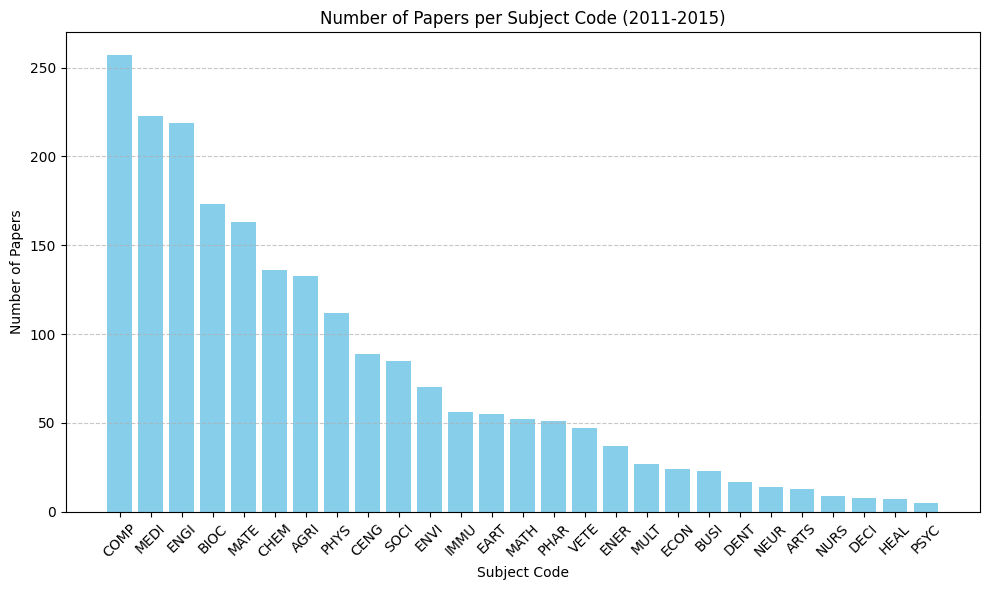

In [121]:
from pyspark.sql.functions import year, to_date, col

# Convert to date and extract year
title_subject_DF = title_subject_DF.withColumn(
    "publication_year_temp", year(to_date("publication_year", "yyyy-MM-dd"))
)
title_subject_DF.show()
start_year = 2011
end_year = 2015
# Replace publication_year only if the transformation was successful
filtered_title_subject_DF = title_subject_DF.filter(
    (col("publication_year_temp") >= start_year) & (col("publication_year_temp") <= end_year)
)

# filtered_title_subject_DF.show()

# Count the number of papers per subject code
subject_count_DF = filtered_title_subject_DF.groupBy("subject_code").count().orderBy("count", ascending=False)

# Convert to Pandas for plotting
subject_count_pd = subject_count_DF.toPandas()

# Plot using Matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(subject_count_pd["subject_code"], subject_count_pd["count"], color='skyblue')
plt.title(f"Number of Papers per Subject Code ({start_year}-{end_year})")
plt.xlabel("Subject Code")
plt.ylabel("Number of Papers")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [147]:
# Select the title and publication year from the DataFrame
title_year_DF = paperDF.select(
    col("abstracts-retrieval-response.coredata.dc:title").alias("title"),
    col("abstracts-retrieval-response.coredata.prism:coverDate").alias("publication_year")
)

# Show the result
title_year_DF.show(truncate=False, n=5)

# Get the shape of the DataFrame
num_rows = title_year_DF.count()
num_cols = len(title_year_DF.columns)
print(f"DataFrame shape: ({num_rows}, {num_cols})")

+-------------------------------------------------------------------------------------------------------------------------------------+----------------+
|title                                                                                                                                |publication_year|
+-------------------------------------------------------------------------------------------------------------------------------------+----------------+
|Guidelines for the use and interpretation of assays for monitoring autophagy (4th edition)1                                          |2021-01-01      |
|A multi-dimensional search for new heavy resonances decaying to boosted WW , WZ , or ZZ boson pairs in the dijet final state at 13 Te|2020-03-01      |
|Measurement of electroweak production of a W boson in association with two jets in proton–proton collisions at √s=13Te               |2020-01-01      |
|Evidence for WW production from double-parton interactions in proton–proton colli

+-------------------------------------------------------------------------------------------------------------------------------------+----------------+
|title                                                                                                                                |publication_year|
+-------------------------------------------------------------------------------------------------------------------------------------+----------------+
|Guidelines for the use and interpretation of assays for monitoring autophagy (4th edition)1                                          |2021            |
|A multi-dimensional search for new heavy resonances decaying to boosted WW , WZ , or ZZ boson pairs in the dijet final state at 13 Te|2020            |
|Measurement of electroweak production of a W boson in association with two jets in proton–proton collisions at √s=13Te               |2020            |
|Evidence for WW production from double-parton interactions in proton–proton colli

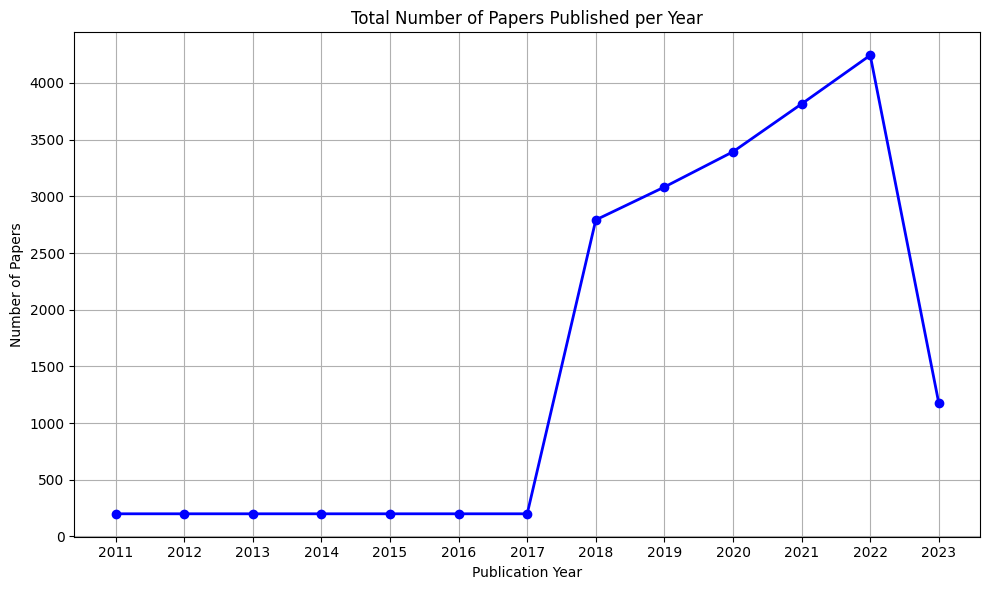

In [144]:
from pyspark.sql.functions import year

# Extract the year from the publication_date and cast to integer
title_year_DF = title_year_DF.withColumn("publication_year", year("publication_year"))

# Show the result to confirm
title_year_DF.show(truncate=False, n=5)

# Group by publication year and count the number of papers
papers_by_year_DF = title_year_DF.groupBy("publication_year").count().orderBy("publication_year")

# Convert the result to Pandas for easier plotting
papers_by_year_pd = papers_by_year_DF.toPandas()

# Plot the result
plt.figure(figsize=(10, 6))
plt.plot(papers_by_year_pd["publication_year"], papers_by_year_pd["count"], marker='o', color='b', linestyle='-', linewidth=2)
plt.title("Total Number of Papers Published per Year")
plt.xlabel("Publication Year")
plt.ylabel("Number of Papers")
plt.xticks(papers_by_year_pd["publication_year"].unique())  # Ensure only integer values are shown on x-axis
plt.grid(True)
plt.tight_layout()
plt.show()
